<div style="background-color: #e3f2fd; border: 2px solid #2196f3; border-radius: 10px; padding: 15px; margin: 10px 0;">
<h4 style="color: #1976d2; margin-top: 0;">Context</h4>

This notebook analyzes the CA-HepTh collaboration network by reconstructing
an **author–author graph** from arXiv metadata (one file per paper),
then exploring:
- global structure and visualization
- centrality measures (degree, betweenness)
- community structure via:
  - k-core decomposition
  - k-clique communities (maximal cliques)

We do **not** use the anonymous author IDs from the original SNAP
`CA-HepTh.txt` file to build our main graph. Instead we rely on cleaned
author names as node identifiers, which makes the network interpretable.
</div>


### Import

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import ast
import pickle
from itertools import combinations
from collections import Counter

<div style="background-color: #e3f2fd; border: 2px solid #2196f3; border-radius: 10px; padding: 15px; margin: 10px 0;">
<h4 style="color: #1976d2; margin-top: 0;">Context</h4>

The heavy preprocessing of the raw `.abs` files (one per paper) has been
performed once beforehand to produce a single CSV file:

- `arxiv_hepth_meta.csv`

Each row corresponds to one paper, with columns such as:
- `paper_id` (numeric part of hep-th ID, e.g. `9201001`)
- `email` (cleaned best-effort)
- `date`, `title`, `subj_class`, `journal_ref`, `comments`
- `authors_list` (Python list of author names)
- `year`
- `n_authors` (number of authors)

In this notebook, we **start from this cleaned CSV** and do not re-parse
the raw `.abs` files, to keep the workflow simple and reproducible.
</div>

### Load and clean metadata

In [3]:
meta_df = pd.read_csv("arxiv_hepth_meta.csv")

Some rows may still contain authors_list as a string representation of a list.

We clean them and remove obvious junk tokens.

In [4]:
def clean_authors_list(x):
    """
    Ensure that `authors_list` is a *clean Python list* of author names.
    - If x is a string representation of a list, parse it safely with ast.literal_eval.
    - Filter out known junk tokens ('and', '2)', initials used alone, etc.).
    """
    if isinstance(x, str):
        try:
            authors = ast.literal_eval(x)
            junk = {'and', '2)', 'Jr.', 'M.', 'P.', 'J.', 'R.'}
            return [author for author in authors if author not in junk]
        except (SyntaxError, ValueError):
            return []
    return x if isinstance(x, list) else []

meta_df["authors_list"] = meta_df["authors_list"].apply(clean_authors_list)
meta_df["n_authors"] = meta_df["authors_list"].apply(len)

print(meta_df["n_authors"].describe())
meta_df.head()

count    29555.000000
mean         1.824970
std          1.193778
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          8.000000
Name: n_authors, dtype: float64


paper_id                          email  \
0   9201001   zuber@poseidon.saclay.cea.fr   
1   9201002             tarlini@fi.infn.it   
2   9201003        dijkgraaf@iassns.bitnet   
3   9201004  nathan@max.physics.sunysb.edu   
4   9201005       irk@pupthy.princeton.edu   

                                          date  \
0  Tue Dec 31 23:54:17 MET 1991 +0100   (37kb)   
1                Thu, 2 JAN 92 12:17 N   (6kb)   
2             Thu, 2 Jan 92 14:06 EST   (54kb)   
3          Thu, 2 Jan 92 20:02:01 EST   (21kb)   
4           Fri, 3 Jan 92 17:09:04 est   (8kb)   

                                               title  \
0  Combinatorics of the Modular Group II: the Kon...   
1  Inomogeneous Quantum Groups as Symmetries of P...   
2  Intersection Theory, Integrable Hierarchies an...   
3  The Heterotic Green-Schwarz Superstring on an ...   
4   Ward Identities in Two-Dimensional String Theory   

                                         authors_raw  \
0                        C. Itzykson and J.-B. Zuber   
1  F.Bonechi, E.Celeghini, R.Giachetti, E.Sorace ...   
2                                  Robbert Dijkgraaf   
3                                   Nathan Berkovits   
4                                   Igor R. Klebanov   

                                      subj_class  \
0  High Energy Physics - Theory; Quantum Algebra   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                            NaN   

                           journal_ref  \
0  Int.J.Mod.Phys. A7 (1992) 5661-5705   
1   Phys.Rev.Lett. 68 (1992) 3718-3720   
2                                  NaN   
3        Nucl.Phys. B379 (1992) 96-120   
4   Mod. Phys. Lett. A7 (1992) 723-732   

                                            comments  year  \
0                                           46 pages  1992   
1                                     5 pags. 0 figs  1992   
2  73 pages, most figures are not included. Lectu...  1992   
3                                           33 pages  1992   
4                                           12 pages  1992   

                          file_path  \
0  paper_meta_info\1992\9201001.abs   
1  paper_meta_info\1992\9201002.abs   
2  paper_meta_info\1992\9201003.abs   
3  paper_meta_info\1992\9201004.abs   
4  paper_meta_info\1992\9201005.abs   

                                        authors_list  n_authors  
0                         [C. Itzykson, J.-B. Zuber]          2  
1  [F.Bonechi, E.Celeghini, R.Giachetti, E.Sorace...          5  
2                                [Robbert Dijkgraaf]          1  
3                                 [Nathan Berkovits]          1  
4                                 [Igor R. Klebanov]          1

<div style="background-color: #c7f2d3ff; border: 2px solid #5bba6bff; border-radius: 10px; padding: 15px; margin: 10px 0;">
<h4 style="color: #5bba6bff; margin-top: 0;">Results</h4>

The cleaned metadata show a typical scientific collaboration pattern:
- Many single-author or small-team publications,
- A long tail of larger teams.

We will now use `authors_list` to reconstruct an interpretable
**author–author collaboration graph**.
</div>


### Build the author collaboration graph

Create an undirected graph where:
- each node = an author (identified by their cleaned name)
- each edge = at least one co-authored paper
- edge attribute "weight" = number of joint papers

In [5]:
G_authors = nx.Graph()

for _, row in meta_df.iterrows():
    paper_id = row["paper_id"]
    authors = row["authors_list"]
    year = row["year"]

    # Skip papers with no valid authors
    if not authors:
        continue

    # Add author nodes and attach paper/year information
    for author in authors:
        if not G_authors.has_node(author):
            # `papers` and `years` are sets to avoid duplicates during construction
            G_authors.add_node(author, papers=set(), years=set())
        G_authors.nodes[author]["papers"].add(paper_id)
        G_authors.nodes[author]["years"].add(year)

    # For each pair of co-authors on the same paper, add/strengthen an edge
    for a1, a2 in combinations(authors, 2):
        if G_authors.has_edge(a1, a2):
            G_authors[a1][a2]["weight"] += 1
        else:
            G_authors.add_edge(a1, a2, weight=1)

# Convert sets to lists for easier display/serialization
for author in G_authors.nodes():
    G_authors.nodes[author]["papers"] = list(G_authors.nodes[author]["papers"])
    G_authors.nodes[author]["years"] = sorted(G_authors.nodes[author]["years"])

print(f"Graph (clean) - Nodes: {G_authors.number_of_nodes()}, Edges: {G_authors.number_of_edges()}")

# Optionally save for later reuse
with open("G_authors_clean.gpickle", "wb") as f:
    pickle.dump(G_authors, f)

# Work on this graph for the rest of the notebook
G = G_authors

Graph (clean) - Nodes: 17809, Edges: 27813


<div style="background-color: #c7f2d3ff; border: 2px solid #5bba6bff; border-radius: 10px; padding: 15px; margin: 10px 0;">
<h4 style="color: #5bba6bff; margin-top: 0;">Results</h4>

The reconstructed author graph has:

- tens of thousands of authors,
- tens of thousands of collaboration links,
- and a structure typical of scientific collaboration networks:
  a dense core of highly connected authors and a large periphery.

This graph is now fully interpretable: each node corresponds to a real
author name, and can be linked back to the papers and years they published.
</div>

<div style="background-color: #e3f2fd; border: 2px solid #2196f3; border-radius: 10px; padding: 15px; margin: 10px 0;">
<h4 style="color: #1976d2; margin-top: 0;">Context</h4>

For visualization and centrality analysis, plotting the full 17k+ node
network would be unreadable. Instead, we:

- extract the **top 300 authors by degree** (number of collaborators),
- work on the induced subgraph `H` of these authors.

This subgraph reveals the structure of the "core" of the collaboration
network while remaining visually manageable.
</div>

### Subgraph of top 300 authors

Select top 300 authors by degree

In [6]:
top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:300]
sub_nodes = [n for n, _ in top_nodes]
H = G.subgraph(sub_nodes).copy()

print(f"Subgraph H - Nodes: {H.number_of_nodes()}, Edges: {H.number_of_edges()}")


Subgraph H - Nodes: 300, Edges: 705


### Visualization utilities

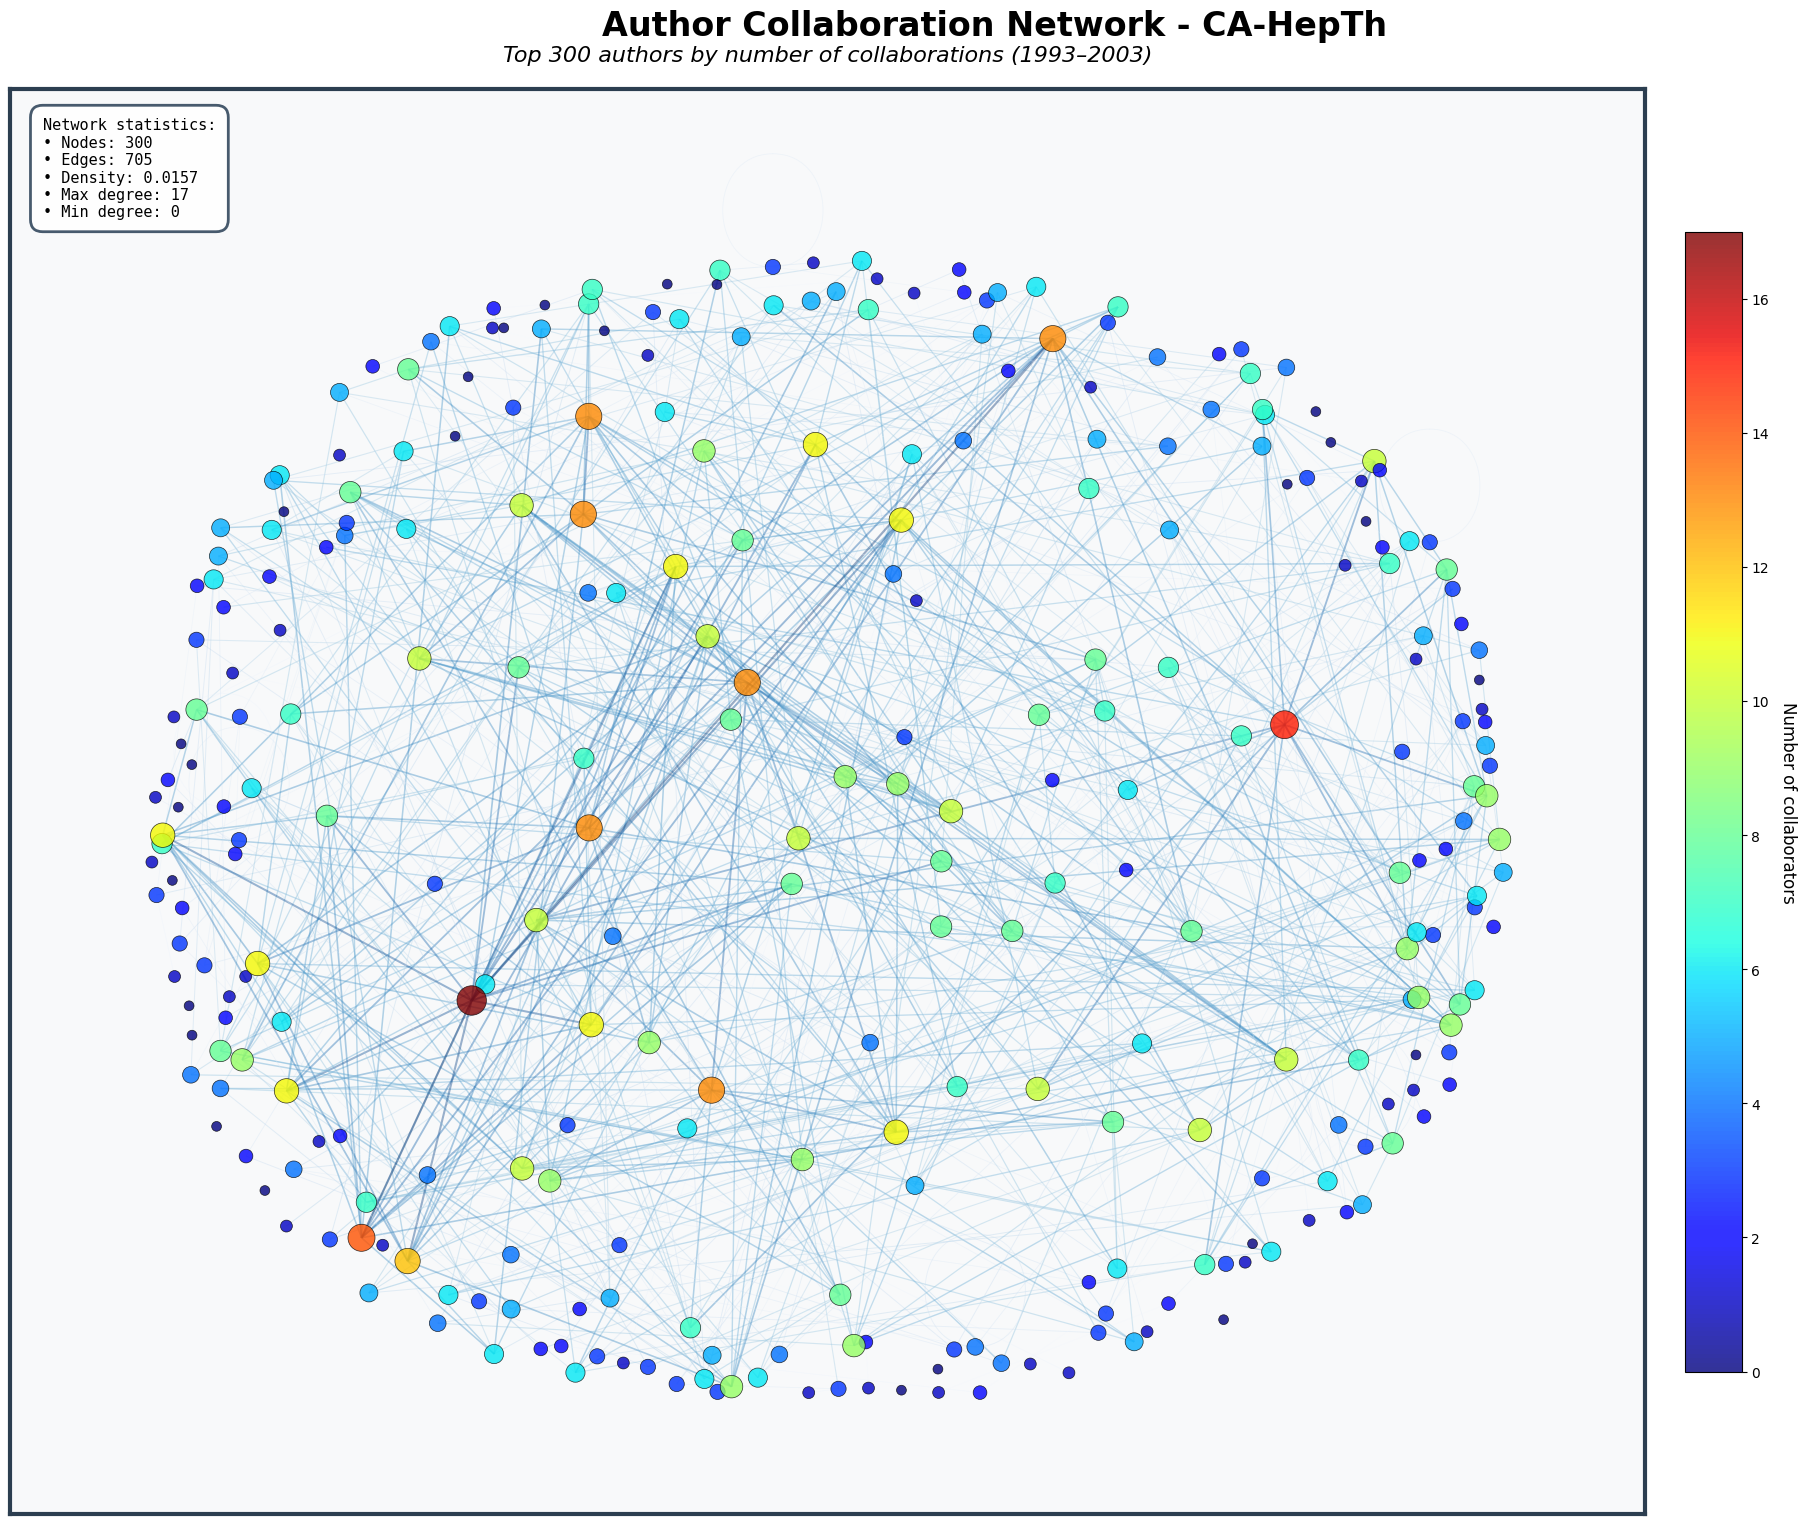

In [ ]:
def compute_edge_properties(H):
    """
    Compute edge colors and widths as a function of the degrees
    of their endpoints.

    Intuition:
    - Edges linking high-degree authors are drawn thicker and darker,
      highlighting strong "hub-to-hub" regions in the graph.
    """
    degrees = dict(H.degree())
    max_degree = max(degrees.values())

    edge_colors = []
    edge_widths = []

    for u, v in H.edges():
        degree_sum = degrees[u] + degrees[v]
        edge_colors.append(degree_sum)
        # Edge width scaled between ~0.3 and 1.0
        edge_widths.append(0.3 + (degree_sum / max_degree * 0.7))

    return edge_colors, edge_widths


def compute_node_properties(H):
    """
    Compute node colors and sizes based on node degree.

    - Color = degree (number of collaborators)
    - Size  = degree, rescaled between 50 and 450

    This emphasizes central 'hub' authors in the visualization.
    """
    degrees = dict(H.degree())
    max_degree = max(degrees.values())
    min_degree = min(degrees.values())

    node_colors = [degrees[node] for node in H.nodes()]
    # Avoid division by zero if all degrees are equal
    if max_degree == min_degree:
        node_sizes = [200 for _ in H.nodes()]
    else:
        node_sizes = [
            50 + (degrees[node] - min_degree) / (max_degree - min_degree) * 400
            for node in H.nodes()
        ]

    return node_colors, node_sizes, max_degree, min_degree


def draw_network_edges(H, pos, ax):
    """Draw edges with colors and widths based on node degrees."""
    edge_colors, edge_widths = compute_edge_properties(H)
    nx.draw_networkx_edges(
        H, pos,
        edge_color=edge_colors,
        edge_cmap=plt.cm.Blues,
        width=edge_widths,
        alpha=0.4,
        ax=ax,
    )


def draw_network_nodes(H, pos, ax):
    """Draw nodes with colors and sizes based on degree."""
    node_colors, node_sizes, max_degree, min_degree = compute_node_properties(H)
    nodes = nx.draw_networkx_nodes(
        H, pos,
        node_color=node_colors,
        node_size=node_sizes,
        cmap=plt.cm.jet,
        alpha=0.8,
        edgecolors="black",
        linewidths=0.5,
        ax=ax,
    )
    return nodes, max_degree, min_degree


def add_titles_and_labels(fig, ax, subtitle=None):
    """
    Ajoute le titre principal et un sous-titre.

    - Le titre principal reste générique (dataset).
    - Le sous-titre peut être personnalisé par type de visualisation.
    """
    fig.suptitle(
        "Author Collaboration Network - CA-HepTh",
        fontsize=24,
        fontweight="bold",
        y=0.95,
    )

    if subtitle is None:
        subtitle = "Top 300 authors by number of collaborations (1993–2003)"

    ax.set_title(
        subtitle,
        fontsize=16,
        pad=20,
        style="italic",
    )


def add_colorbar(nodes, ax):
    """Attach a colorbar explaining the node color scale."""
    cbar = plt.colorbar(nodes, ax=ax, shrink=0.8, pad=0.02)
    cbar.set_label("Number of collaborators", rotation=270, labelpad=20, fontsize=12)
    return cbar


def add_decorative_frame(ax):
    """Add a dark frame around the plot area for aesthetics."""
    for spine in ax.spines.values():
        spine.set_edgecolor("#2c3e50")
        spine.set_linewidth(3)


def add_statistics_box(H, max_degree, min_degree, ax):
    """Add a small textbox with basic network statistics for H."""
    textstr = f"""Network statistics:
• Nodes: {H.number_of_nodes():,}
• Edges: {H.number_of_edges():,}
• Density: {nx.density(H):.4f}
• Max degree: {max_degree}
• Min degree: {min_degree}"""

    props = dict(
        boxstyle="round,pad=0.8",
        facecolor="white",
        alpha=0.9,
        edgecolor="#34495e",
        linewidth=2,
    )
    ax.text(
        0.02,
        0.98,
        textstr,
        transform=ax.transAxes,
        fontsize=11,
        verticalalignment="top",
        bbox=props,
        family="monospace",
    )


def configure_axes(ax):
    """Hide axes ticks and add a faint grid."""
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.grid(True, alpha=0.1, linestyle="--", linewidth=0.5)


def plot_collaboration_network(H, figsize=(20, 16)):
    """
    Main function to display the collaboration network H with
    all visual enhancements.
    """
    plt.style.use("default")
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, facecolor="#f8f9fa")

    # Spring layout: force-directed drawing (attractive/repulsive forces)
    pos = nx.spring_layout(H, seed=42, k=1.5, iterations=50)

    draw_network_edges(H, pos, ax)
    nodes, max_degree, min_degree = draw_network_nodes(H, pos, ax)

    add_titles_and_labels(fig, ax, subtitle=None)
    add_colorbar(nodes, ax)
    add_decorative_frame(ax)
    add_statistics_box(H, max_degree, min_degree, ax)
    configure_axes(ax)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# %%
plot_collaboration_network(H)

<div style="background-color: #c7f2d3ff; border: 2px solid #5bba6bff; border-radius: 10px; padding: 15px; margin: 10px 0;">
<h4 style="color: #5bba6bff; margin-top: 0;">Results</h4>

The visualization clearly shows:
- A **dense central core** of highly collaborative authors,
- A surrounding layer of less connected authors,
- A structure typical of **scale-free networks** (few hubs, many low-degree nodes).

Node size and color both encode the **number of collaborators**, making it
easy to spot central figures in the hep-th community.
</div>


### Ego-network of the most central author

Central node: Edward Witten


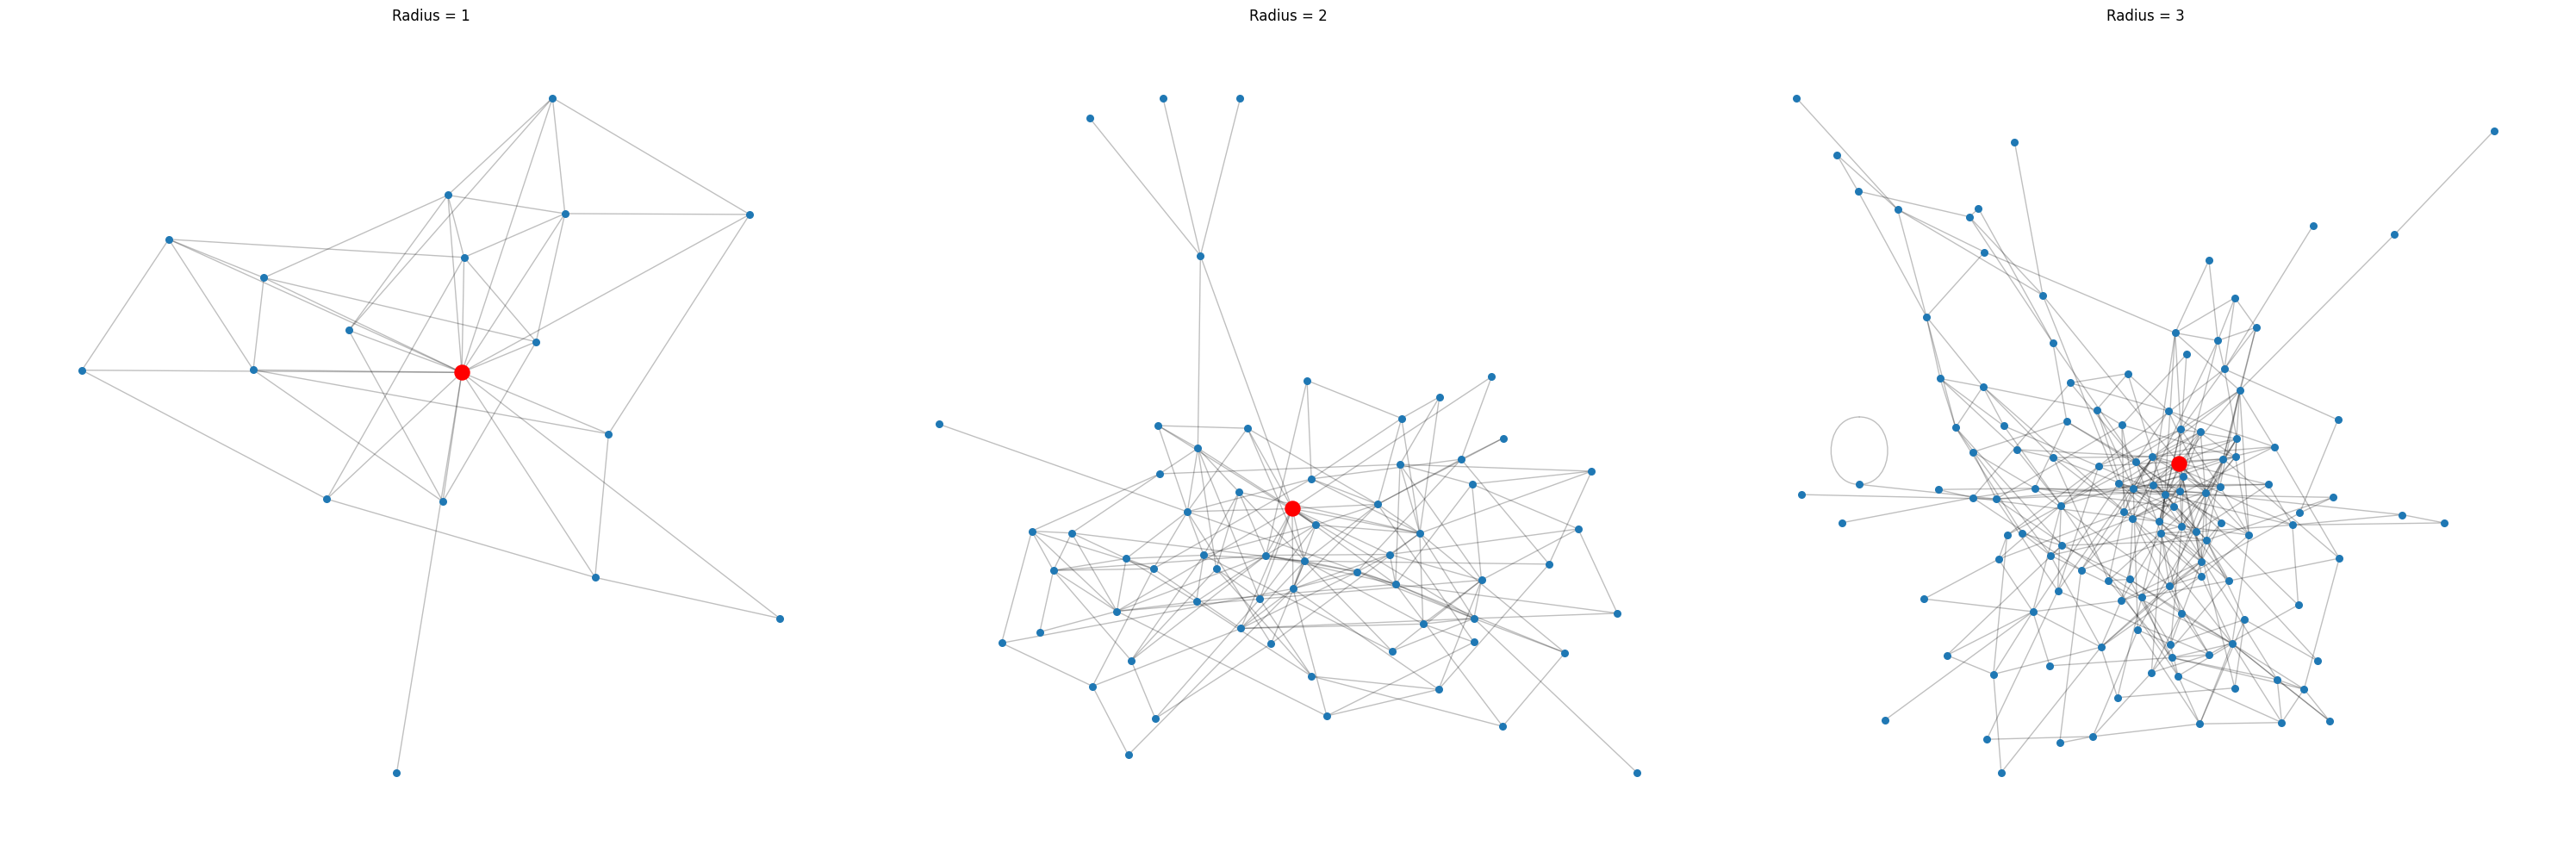

In [8]:
def show_graph_from_center(H, central_node, ax, title=None):
    """
    Simple ego-network visualization around a given central node.
    """
    pos = nx.spring_layout(H, seed=42)

    nx.draw_networkx_nodes(H, pos, node_size=30, ax=ax)
    nx.draw_networkx_edges(H, pos, alpha=0.25, ax=ax)
    nx.draw_networkx_nodes(
        H, pos,
        nodelist=[central_node],
        node_size=150,
        node_color="red",
        ax=ax,
    )

    ax.set_axis_off()
    if title is not None:
        ax.set_title(title)

# Central node = author with highest degree in H
central_node = max(H.degree, key=lambda x: x[1])[0]
print("Central node:", central_node)

# Plot ego-networks with radius 1, 2, 3
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
for ax, radius in zip(axes, [1, 2, 3]):
    ego = nx.ego_graph(H, central_node, radius=radius)
    show_graph_from_center(ego, central_node, ax, title=f"Radius = {radius}")

plt.tight_layout()
plt.show()


<div style="background-color: #e3f2fd; border: 2px solid #2196f3; border-radius: 10px; padding: 15px; margin: 10px 0;">
<h4 style="color: #1976d2; margin-top: 0;">Context</h4>

We now turn to **centrality analysis** on the subgraph `H`:

- **Degree centrality** → how many distinct co-authors an author has.
- **Betweenness centrality** → how often an author sits on shortest paths,
  acting as a broker between different parts of the network.

Together, they help distinguish prolific collaborators from structural brokers.
</div>

### Degree centrality

Top 10 authors by degree centrality:
1. Edward Witten: 0.056856
2. S. Ferrara: 0.050167
3. Andrew Strominger: 0.046823
4. K.S. Stelle: 0.043478
5. E. Bergshoeff: 0.043478
6. Jerome P. Gauntlett: 0.043478
7. Hirosi Ooguri: 0.043478
8. Jaemo Park: 0.043478
9. Michael R. Douglas: 0.043478
10. Shamit Kachru: 0.040134


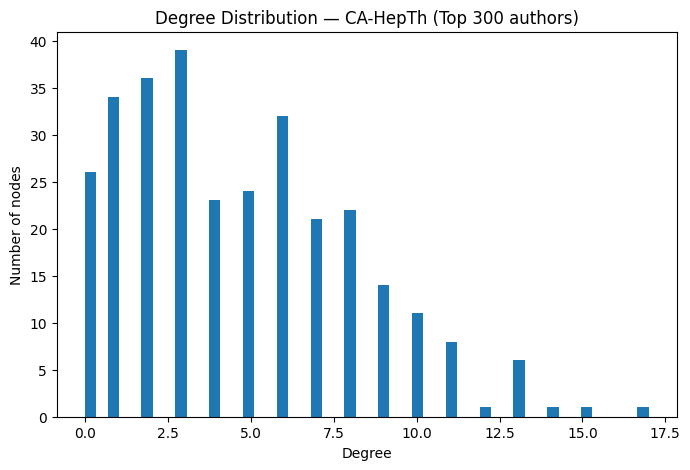

In [9]:
deg_centrality = nx.degree_centrality(H)

top_degree = sorted(deg_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 authors by degree centrality:")
for i, (author, centrality) in enumerate(top_degree, 1):
    print(f"{i}. {author}: {centrality:.6f}")

# %%
degrees = [d for _, d in H.degree()]

plt.figure(figsize=(8, 5))
plt.hist(degrees, bins=50)
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.title("Degree Distribution — CA-HepTh (Top 300 authors)")
plt.show()

### Betweenness centrality

In [ ]:
# Approximate betweenness (k sampled nodes) to keep computation reasonable
bc = nx.betweenness_centrality(H, k=300, seed=42)

top_betweenness = sorted(bc.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 authors by betweenness centrality:")
for i, (author, val) in enumerate(top_betweenness, 1):
    print(f"{i}. {author}: {val:.6f}")


<div style="background-color: #c7f2d3ff; border: 2px solid #5bba6bff; border-radius: 10px; padding: 15px; margin: 10px 0;">
<h4 style="color: #5bba6bff; margin-top: 0;">Results</h4>

- **High-degree authors** are prolific collaborators.
- **High-betweenness authors** act as bridges between subgroups.
- Some authors are high in both measures: they form the **backbone** of the
  hep-th collaboration network.
</div>

<div style="background-color: #e3f2fd; border: 2px solid #2196f3; border-radius: 10px; padding: 15px; margin: 10px 0;">
<h4 style="color: #1976d2; margin-top: 0;">Context</h4>

We now explore **community structure** using two complementary approaches:

1. **k-core decomposition** → nested, non-overlapping cores based on minimum degree.
2. **k-clique communities** → overlapping dense groups based on maximal cliques.

Both reveal different aspects of how research groups are organized:
- k-core = robustness and global position,
- k-cliques = tight collaboration clusters.
</div>

### k-core decomposition

In [10]:
# Remove self-loops if any, then compute k-core index for each node
H_clean = H.copy()
H_clean.remove_edges_from(nx.selfloop_edges(H_clean))
kcore_communities = nx.core_number(H_clean)

core_values = list(kcore_communities.values())
core_distribution = Counter(core_values)
max_core, min_core = max(core_values), min(core_values)

print(f"K-core distribution: {min_core} to {max_core} ({len(set(core_values))} levels)")
print("Nodes per k-core level:")
for k in sorted(core_distribution.keys()):
    print(f"  k-core {k}: {core_distribution[k]} nodes")

sample_nodes = list(H.nodes())[:5]
print("\nExamples:")
for node in sample_nodes:
    print(f"  '{node}': k-core = {kcore_communities[node]}")

max_kcore_authors = [node for node, core in kcore_communities.items() if core == max_core]
print(f"\nCore authors (k-core {max_core}): {len(max_kcore_authors)} authors")
print(f"Examples: {max_kcore_authors[:5]}")


K-core distribution: 0 to 6 (7 levels)
Nodes per k-core level:
  k-core 0: 27 nodes
  k-core 1: 53 nodes
  k-core 2: 47 nodes
  k-core 3: 53 nodes
  k-core 4: 86 nodes
  k-core 5: 27 nodes
  k-core 6: 7 nodes

Examples:
  'K.S. Stelle': k-core = 6
  'Joaquim Gomis': k-core = 4
  'Bernard de Wit': k-core = 3
  'Ruben Minasian': k-core = 4
  'H.J. de Vega': k-core = 1

Core authors (k-core 6): 7 authors
Examples: ['K.S. Stelle', 'M.J. Duff', 'C.N. Pope', 'M. Cvetic', 'H. Lu']


### Add k-core communities as node attribute

In [11]:
def add_kcore_communities(graph):
    """
    Add 'kcore_community' attribute to each node, equal to its k-core index.

    The k-core index of a node is the highest k such that the node belongs
    to the k-core subgraph (where all nodes have degree >= k within that subgraph).
    """
    G_with_communities = graph.copy()

    # Clean self-loops for core_number() to behave as expected
    G_clean = G_with_communities.copy()
    G_clean.remove_edges_from(nx.selfloop_edges(G_clean))

    kcore_values = nx.core_number(G_clean)

    for node in G_with_communities.nodes():
        G_with_communities.nodes[node]["kcore_community"] = kcore_values[node]

    return G_with_communities

H_with_communities = add_kcore_communities(H)

In [ ]:
def compute_node_properties_by_community(H):
    """
    Use degree to set node sizes (as before),
    but color nodes by their k-core index ('kcore_community').
    """
    _, node_sizes, max_degree, min_degree = compute_node_properties(H)
    node_colors = [H.nodes[n].get("kcore_community", 0) for n in H.nodes()]
    return node_colors, node_sizes, max_degree, min_degree


def draw_network_nodes_by_community(H, pos, ax):
    """Draw nodes using k-core index as color."""
    node_colors, node_sizes, max_degree, min_degree = compute_node_properties_by_community(H)
    nodes = nx.draw_networkx_nodes(
        H, pos,
        node_color=node_colors,
        node_size=node_sizes,
        cmap=plt.cm.jet,
        alpha=0.9,
        edgecolors="black",
        linewidths=0.5,
        ax=ax,
    )
    return nodes, max_degree, min_degree


def add_colorbar_community(nodes, ax):
    """Colorbar for k-core index."""
    cbar = plt.colorbar(nodes, ax=ax, shrink=0.8, pad=0.02)
    cbar.set_label("k-core index (community)", rotation=270, labelpad=20, fontsize=12)
    return cbar


def plot_collaboration_network_by_community(H, figsize=(20, 16)):
    """
    Visualization where node colors represent k-core communities.
    """
    plt.style.use("default")
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, facecolor="#f8f9fa")

    pos = nx.spring_layout(H, seed=42, k=1.5, iterations=50)

    draw_network_edges(H, pos, ax)
    nodes, max_degree, min_degree = draw_network_nodes_by_community(H, pos, ax)

    add_titles_and_labels(fig, ax, subtitle="Node colors represent k-core communities")
    add_colorbar_community(nodes, ax)
    add_decorative_frame(ax)
    add_statistics_box(H, max_degree, min_degree, ax)
    configure_axes(ax)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()


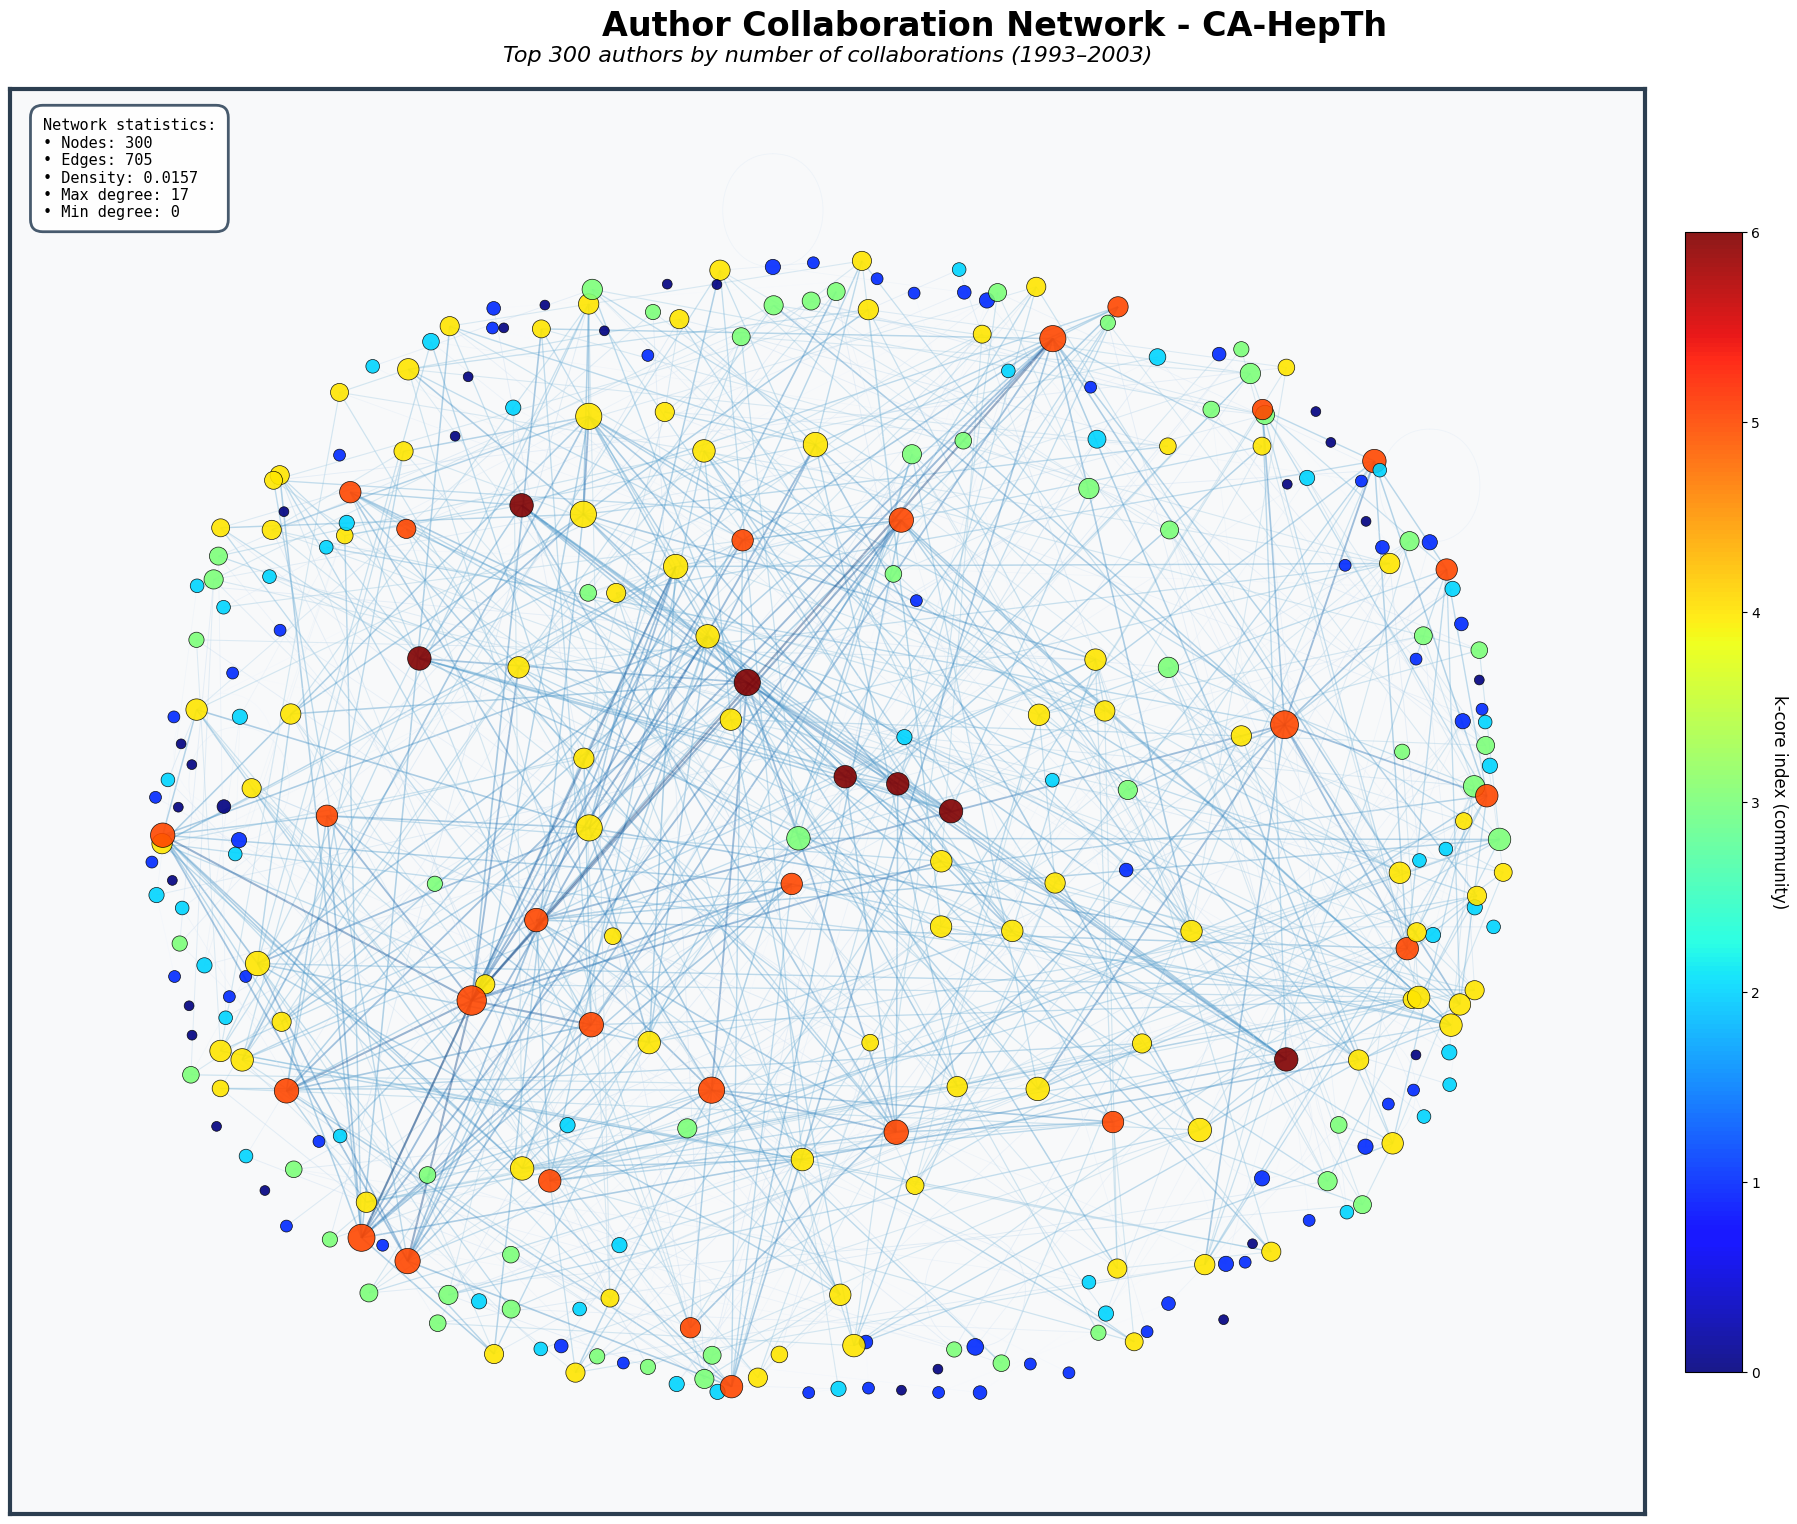

In [13]:
plot_collaboration_network_by_community(H_with_communities)

### k-clique communities (maximal cliques)

In [14]:
def add_kclique_communities(graph, k=3):
    """
    Add, for each node, the list of maximal cliques of size >= k it belongs to.

    Returns
    -------
    G_with_communities : networkx.Graph
        Copy of the graph with node attribute 'kclique_communities'
        (list of clique IDs).
    cliques_filtered : list[list]
        List of maximal cliques (as lists of nodes), filtered by size >= k.
    """
    G_with_communities = graph.copy()

    # Remove self-loops and find all maximal cliques
    G_clean = G_with_communities.copy()
    G_clean.remove_edges_from(nx.selfloop_edges(G_clean))
    all_cliques = list(nx.find_cliques(G_clean))

    # Keep only cliques of size >= k
    cliques_filtered = [c for c in all_cliques if len(c) >= k]

    # Initialize attribute on all nodes
    for node in G_with_communities.nodes():
        G_with_communities.nodes[node]["kclique_communities"] = []

    # Assign clique IDs
    for clique_id, clique in enumerate(cliques_filtered):
        for node in clique:
            G_with_communities.nodes[node]["kclique_communities"].append(clique_id)

    return G_with_communities, cliques_filtered

H_with_kcliques, cliques = add_kclique_communities(H, k=3)


In [ ]:
def compute_node_properties_by_kclique(H, clique_id=None):
    """
    Node sizes = degree (as before),
    node colors based on k-clique membership.

    - If clique_id is None:
        color = number of maximal cliques the node belongs to.
    - Otherwise:
        color = 1 if node is in the selected clique, 0 otherwise.
    """
    _, node_sizes, max_degree, min_degree = compute_node_properties(H)

    if clique_id is None:
        node_colors = [
            len(H.nodes[n].get("kclique_communities", []))
            for n in H.nodes()
        ]
    else:
        node_colors = [
            1 if clique_id in H.nodes[n].get("kclique_communities", []) else 0
            for n in H.nodes()
        ]

    return node_colors, node_sizes, max_degree, min_degree


def draw_network_nodes_by_kclique(H, pos, ax, clique_id=None):
    """Draw nodes colored based on k-clique membership."""
    node_colors, node_sizes, max_degree, min_degree = compute_node_properties_by_kclique(
        H, clique_id=clique_id
    )
    nodes = nx.draw_networkx_nodes(
        H, pos,
        node_color=node_colors,
        node_size=node_sizes,
        cmap=plt.cm.jet,
        alpha=0.9,
        edgecolors="black",
        linewidths=0.5,
        ax=ax,
    )
    return nodes, max_degree, min_degree


def add_colorbar_kclique(nodes, ax, clique_id=None):
    """Colorbar for k-clique based coloring."""
    cbar = plt.colorbar(nodes, ax=ax, shrink=0.8, pad=0.02)
    if clique_id is None:
        cbar.set_label("Number of maximal cliques", rotation=270, labelpad=20, fontsize=12)
    else:
        cbar.set_label(f"Membership of clique #{clique_id}", rotation=270, labelpad=20, fontsize=12)
    return cbar


def plot_collaboration_network_by_kclique(H, figsize=(20, 16), clique_id=None):
    """
    Visualization where node colors represent:
    - either the number of maximal cliques per node (clique_id=None),
    - or membership in a specific clique (clique_id specified).
    """
    plt.style.use("default")
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, facecolor="#f8f9fa")

    pos = nx.spring_layout(H, seed=42, k=1.5, iterations=50)

    draw_network_edges(H, pos, ax)
    nodes, max_degree, min_degree = draw_network_nodes_by_kclique(H, pos, ax, clique_id=clique_id)

    add_titles_and_labels(fig, ax, subtitle="Node colors represent k-clique membership")
    add_colorbar_kclique(nodes, ax, clique_id=clique_id)
    add_decorative_frame(ax)
    add_statistics_box(H, max_degree, min_degree, ax)
    configure_axes(ax)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

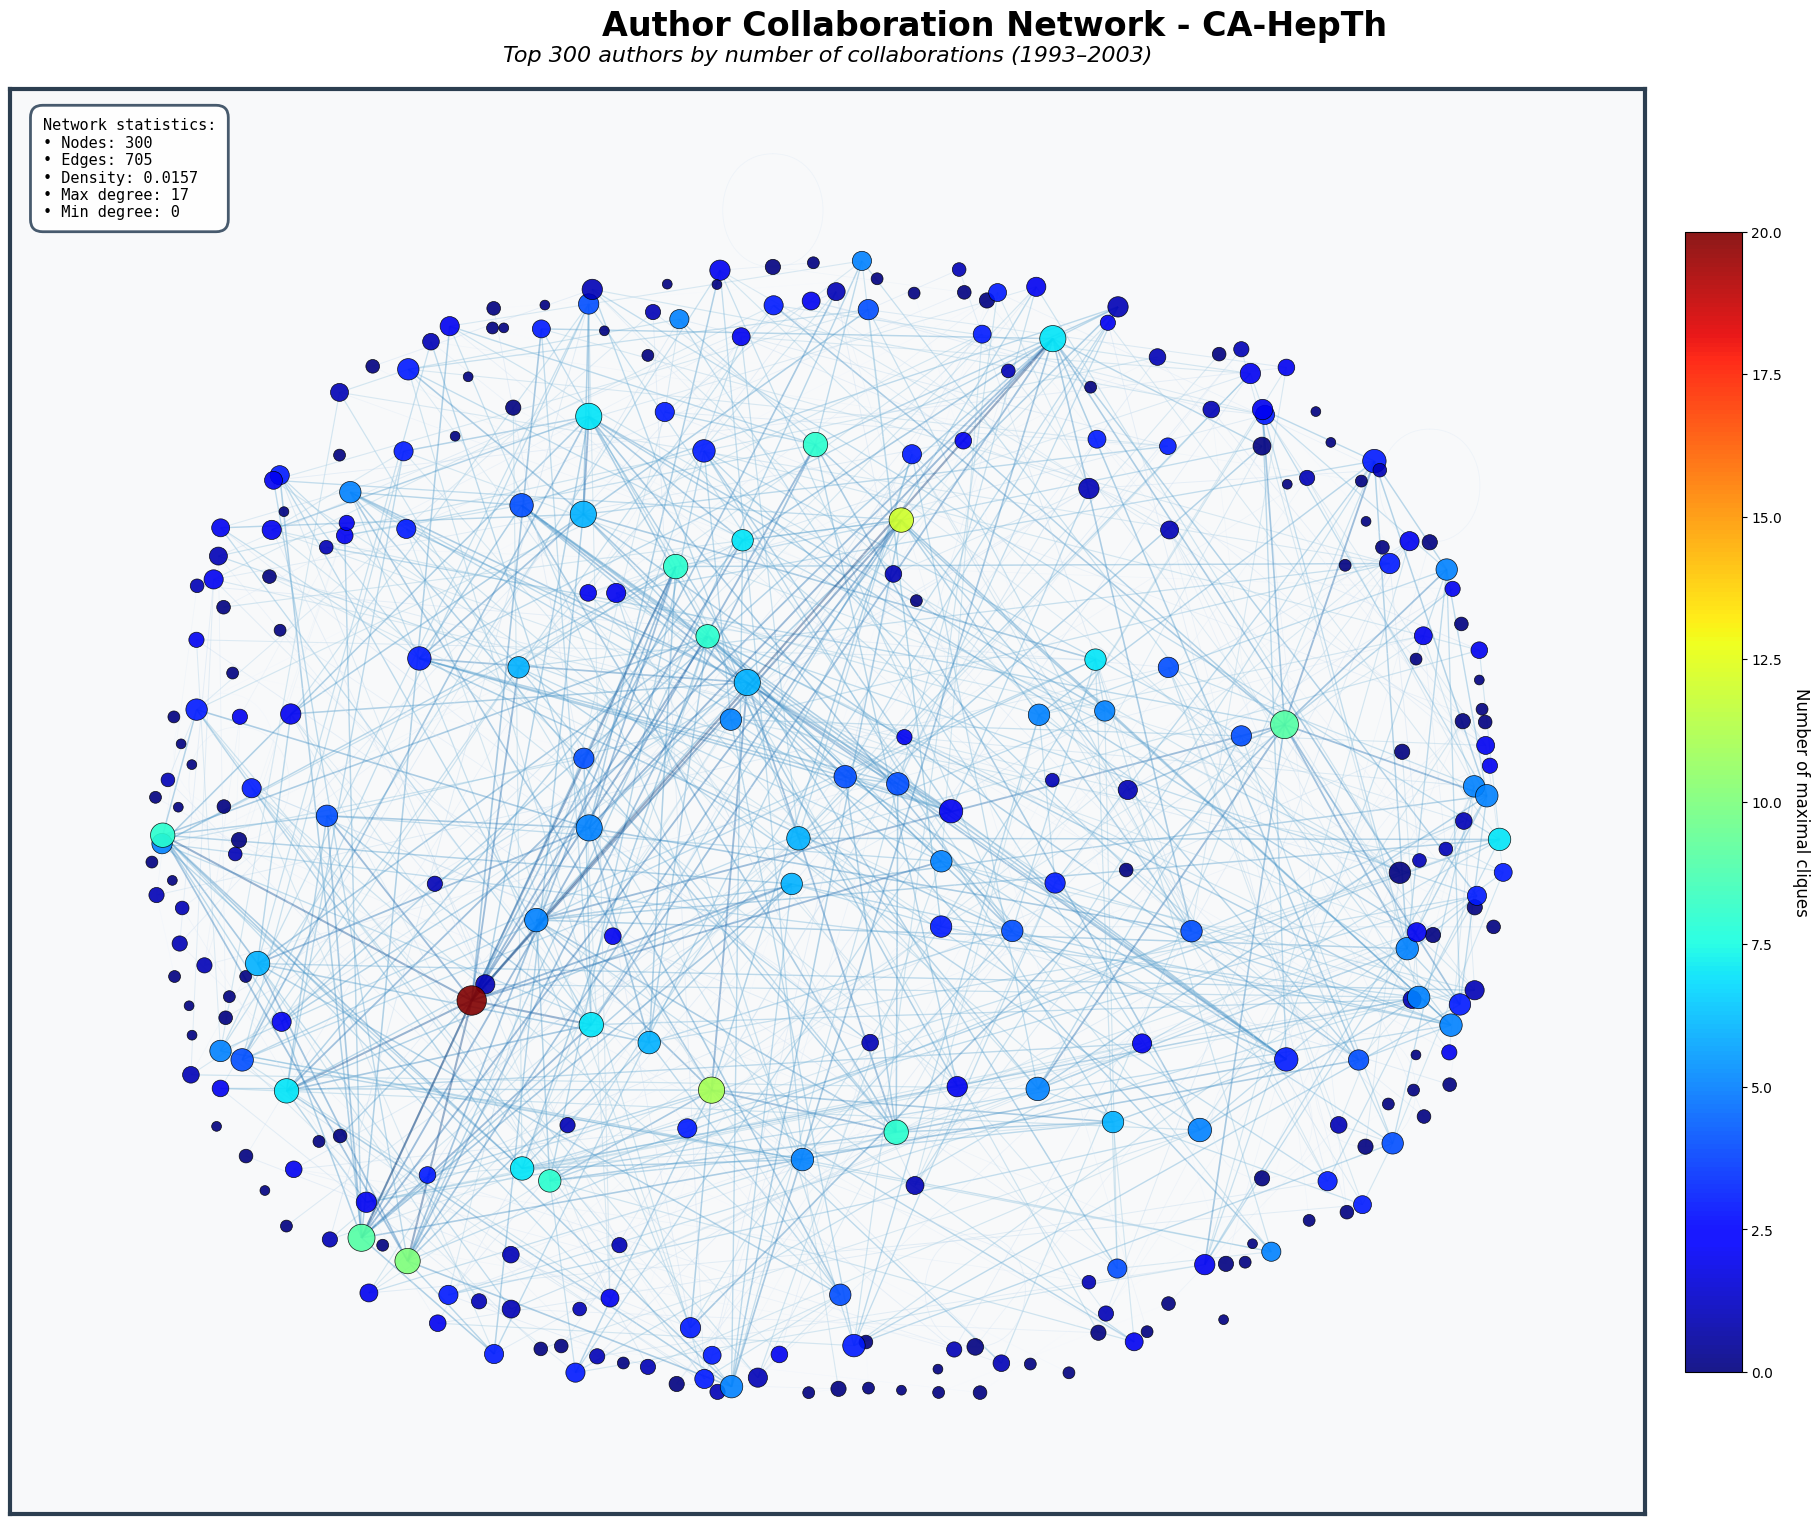

In [16]:
plot_collaboration_network_by_kclique(H_with_kcliques)

<div style="background-color: #f2eec7ff; border: 2px solid #baaf5bff; border-radius: 10px; padding: 15px; margin: 10px 0;">
<h4 style="color: #baaf5bff; margin-top: 0;">Note</h4>

- k-core communities emphasize **global structural robustness**:
  authors that stay in the graph even when low-degree nodes are removed.
- k-clique communities emphasize **local dense collaboration patterns**:
  tightly knit teams and overlapping research groups.

Combining both views gives a nuanced picture of the hep-th ecosystem:
who forms the backbone, and where the tight clusters of collaboration live.
</div>